# Homework: Implement a Mixture of Experts Model

## Overview

In this homework, you'll implement a Mixture of Experts (MoE) model for classifying points generated from two Gaussian distributions.

Please submit your Jupyter Notebook with all the completed tasks and questions answered.

In [1]:
# Import Libraries

import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Generate the Dataset
def generate_data(n_samples=2000):
  X = torch.zeros(n_samples, 2)
  y = torch.zeros(n_samples, dtype=torch.long)

  # Generate samples from two Gaussian distributions
  X[:n_samples//2] = torch.randn(n_samples//2, 2) + torch.Tensor([3,2])
  X[n_samples//2:] = torch.randn(n_samples//2, 2) + torch.Tensor([-3,2])

  # Labels
  for i in range(X.shape[0]):
    if X[i].norm() > math.sqrt(13):
      y[i] = 1

  X[:, 1] = X[:, 1] - 2

  return X, y

data, labels = generate_data()

Question: Plot the generated dataset. Do you think a linear model would be able to separate the classes well?

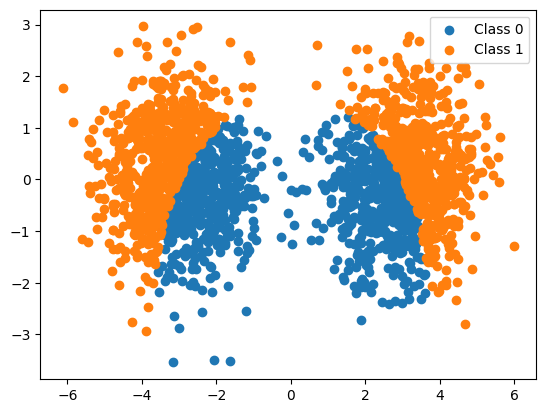

In [3]:
# Visualize the data
# TODO
plt.scatter(data[labels==0, 0], data[labels==0, 1], label='Class 0')
plt.scatter(data[labels==1, 0], data[labels==1, 1], label='Class 1')
plt.legend()
plt.show()

## Expert Model

Task: Implement the Expert model. It should be a simple neural network with one linear layer.



In [4]:
class Expert(nn.Module):
    # TODO
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(2, 1)
    
    def forward(self, x):
        return self.fc(x)


## Gating Network

Task: Implement the Gating Network. It should output the probabilities for choosing each expert.

In [5]:
class GatingNetwork(nn.Module):
  # TODO
  def __init__(self, num_experts):
    super().__init__()
    self.fc = nn.Linear(2, num_experts)
  
  def forward(self, x):
    return F.softmax(self.fc(x), dim=1)



## Mixture of Experts

Task: Implement the Mixture of Experts model. This model should utilize the Expert and Gating Network models to make a final prediction.

In [6]:
class MixtureOfExperts(nn.Module):
  # TODO
  def __init__(self, num_experts=2):
    super().__init__()
    self.experts = nn.ModuleList([Expert() for _ in range(num_experts)])
    # self.experts = [Expert() for _ in range(num_experts)]
    self.gating_network = GatingNetwork(num_experts)

  def forward(self, x):
    g = self.gating_network(x)
    output = torch.zeros(x.shape[0], 1)
    for i, expert in enumerate(self.experts):
      output += g[:, i].view(-1, 1) * expert(x)
    return output
        


## Training Loop

Task: Write a training loop to train the Mixture of Experts model. Use binary cross-entropy loss and an Adam optimizer. Also, implement a learning rate scheduler that decays the learning rate.

In [7]:
# Define the model, loss, and optimizer
model = MixtureOfExperts(num_experts=2) # TODO
criterion = nn.BCEWithLogitsLoss() # TODO 
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) # TODO

# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.8) # TODO

# Convert data and labels to float tensors
data_tensor = data.float()
labels_tensor = labels.view(-1, 1).float()

# Training loop
num_epochs = 5000 #
for epoch in range(num_epochs):
    # Forward pass
    # TODO
    output = model(data_tensor)

    # Backward pass and optimization
    # TODO
    loss = criterion(output, labels_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Decay the learning rate
    # TODO
    scheduler.step()

    # Print out the loss and accuracy
    if (epoch+1) % 500 == 0:
        accuracy = ((output > 0.5) == labels_tensor).sum().item() / labels_tensor.size(0)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}")



Epoch 500/5000, Loss: 0.1907, Accuracy: 0.9430
Epoch 1000/5000, Loss: 0.1668, Accuracy: 0.9495
Epoch 1500/5000, Loss: 0.1546, Accuracy: 0.9505
Epoch 2000/5000, Loss: 0.1462, Accuracy: 0.9510
Epoch 2500/5000, Loss: 0.1402, Accuracy: 0.9525
Epoch 3000/5000, Loss: 0.1357, Accuracy: 0.9535
Epoch 3500/5000, Loss: 0.1320, Accuracy: 0.9530
Epoch 4000/5000, Loss: 0.1289, Accuracy: 0.9535
Epoch 4500/5000, Loss: 0.1262, Accuracy: 0.9545
Epoch 5000/5000, Loss: 0.1239, Accuracy: 0.9545


## Decision Boundaries
Task: Plot the decision boundaries of the two experts, the gating network and the final model

/ext3/miniconda3/lib/python3.8/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


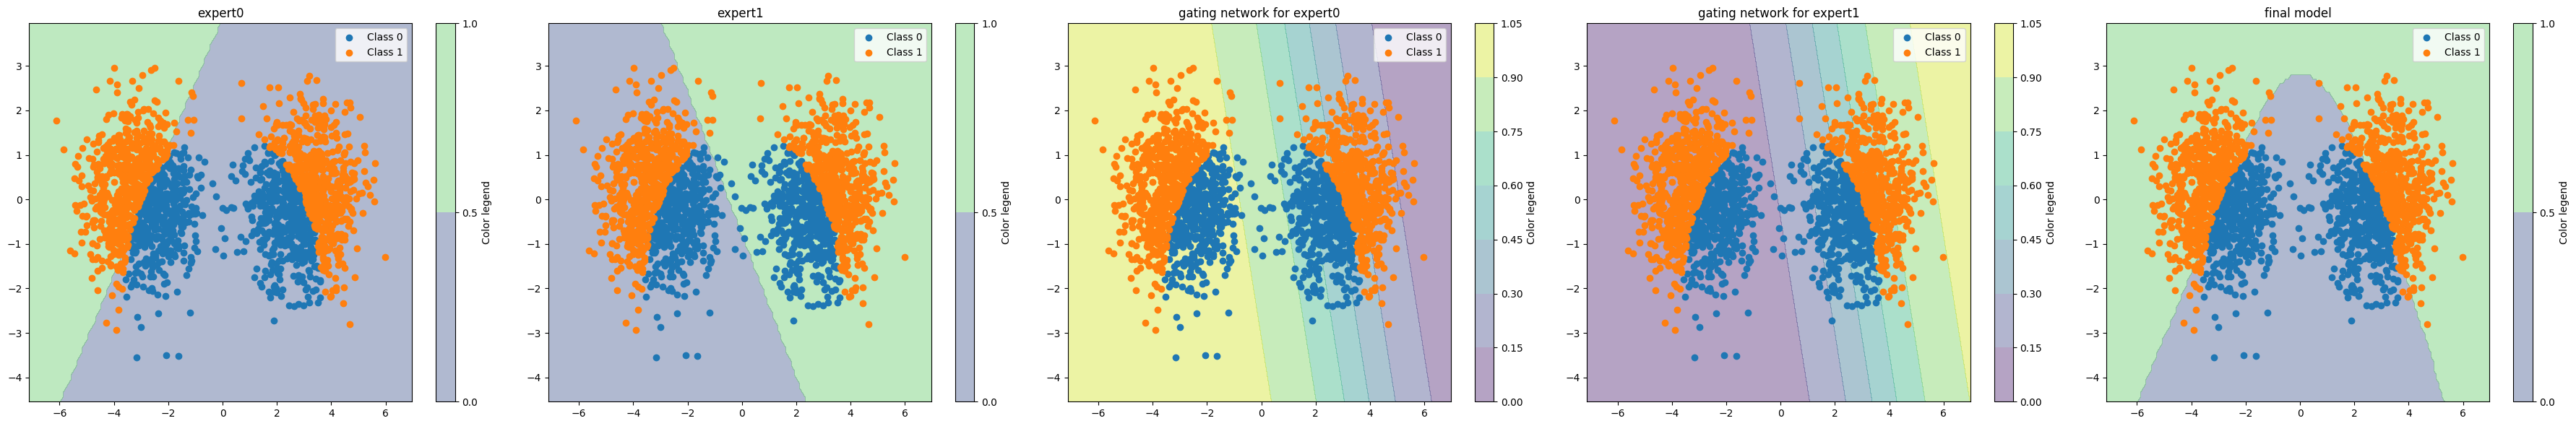

In [8]:
# TODO
# Visualize the decision boundary
x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1

xx, yy = torch.meshgrid(torch.arange(x_min, x_max, 0.1), torch.arange(y_min, y_max, 0.1))
boundry_input = torch.cat([xx.reshape(-1, 1), yy.reshape(-1, 1)], dim=1).float()

def plot(model):
    Z = {}
    for idx in range(len(model.experts)):
        Z[f'expert{idx}'] = model.experts[idx](boundry_input)
    gates = model.gating_network(boundry_input)
    for idx in range(gates.shape[1]):
        Z[f'gating network for expert{idx}'] = model.gating_network(boundry_input)[:,idx]
    Z['final model'] = model(boundry_input)

    fig, axes = plt.subplots(nrows=1, ncols=len(Z), figsize=((len(Z)+1)*6, 6))
    Z = list(Z.items())

    for idx in range(len(Z)):
        submodel, z = Z[idx]
        z = z.reshape(xx.shape)
        if submodel.startswith('gating network'):
            contour = axes[idx].contourf(xx, yy, z.detach(), alpha=0.4)
        else:
            contour = axes[idx].contourf(xx, yy, z.detach()>0.5, alpha=0.4)
        axes[idx].scatter(data[labels==0, 0], data[labels==0, 1], label='Class 0')

        axes[idx].scatter(data[labels==1, 0], data[labels==1, 1], label='Class 1')
        axes[idx].legend()

        axes[idx].set_title(submodel)

        cbar = fig.colorbar(contour, ax=axes[idx])
        cbar.set_label('Color legend')
    plt.tight_layout()
    plt.show()
    
plot(model)

Question: Analyze the decision boundaries. What differences do you observe between the experts? How does the gating network decide between the two?

The two experts have different expertise, resulting in different decision boundaries. 
In my case, expert0 has a good performance when classifying class1 in the left half, while overlooking class1 points in the right half,
and expert1 maily seperates the whole group of points evenly.
The gating network then has its decision boundary on the right half of the plot, corretly classifying class1 in the right half itself,
then it prefers expert0 on its left side, and expert1 on its right side.

(Note that I think the result relies on initialization. For just once, I accidentaly get expert0 and expert1 seperating left and right correctly, and the gating network has its decision boundry in the middle. However, I can hardly get that perfect result again.)

## Bonus Task (2 points)
Try increasing the number of experts. How does the model complexity and decision boundary change? (You don't need to show your code for the new models, just plot the new decision boundaries and explain what did you find from the plots)



In [9]:
# train a new model
# Define the model, loss, and optimizer
model2 = MixtureOfExperts(num_experts=5) # TODO
criterion = nn.BCEWithLogitsLoss() # TODO 
optimizer = torch.optim.Adam(model2.parameters(), lr=0.01) # TODO

# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.8) # TODO

# Convert data and labels to float tensors
data_tensor = data.float()
labels_tensor = labels.view(-1, 1).float()

# Training loop
num_epochs = 5000 #
for epoch in range(num_epochs):
    # Forward pass
    # TODO
    output = model2(data_tensor)

    # Backward pass and optimization
    # TODO
    loss = criterion(output, labels_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Decay the learning rate
    # TODO
    scheduler.step()

    # Print out the loss and accuracy
    if (epoch+1) % 500 == 0:
        accuracy = ((output > 0.5) == labels_tensor).sum().item() / labels_tensor.size(0)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}")

Epoch 500/5000, Loss: 0.1165, Accuracy: 0.9605
Epoch 1000/5000, Loss: 0.0770, Accuracy: 0.9695
Epoch 1500/5000, Loss: 0.0664, Accuracy: 0.9695
Epoch 2000/5000, Loss: 0.0618, Accuracy: 0.9715
Epoch 2500/5000, Loss: 0.0591, Accuracy: 0.9720
Epoch 3000/5000, Loss: 0.0572, Accuracy: 0.9730
Epoch 3500/5000, Loss: 0.0557, Accuracy: 0.9735
Epoch 4000/5000, Loss: 0.0544, Accuracy: 0.9740
Epoch 4500/5000, Loss: 0.0533, Accuracy: 0.9745
Epoch 5000/5000, Loss: 0.0522, Accuracy: 0.9745


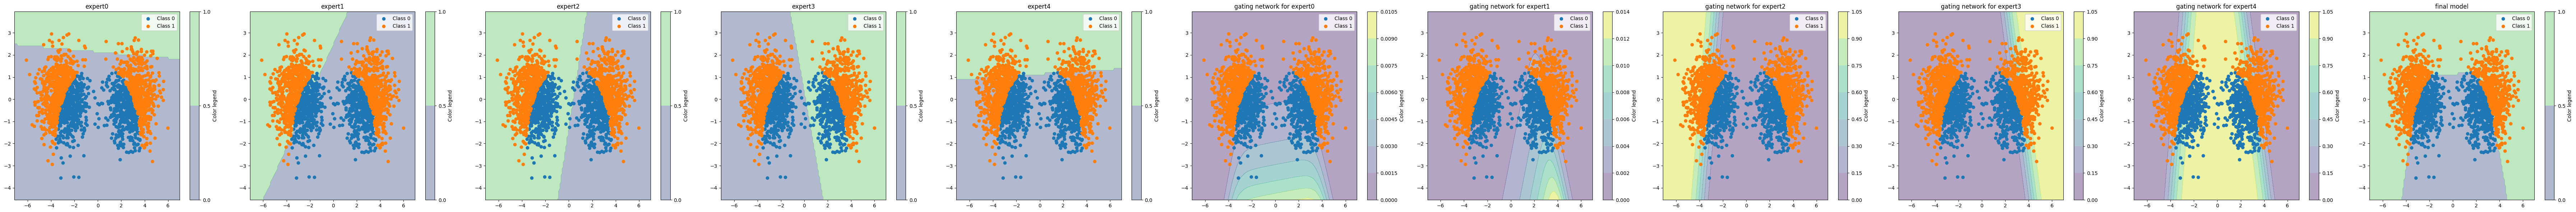

In [10]:
plot(model2)

The decision boundaries end up finding the correct classification boundry, while experts are just seperating points evenly. 
The final decision boundary is complex, and the weird dip in the middel indicates overfitting.